# Introduction to Deep Learning - Week 4

## GAN Kaggle Mini Project

**Github Link** https://github.com/conditas/GANProject

This project involves building a GAN model to create Monet-style images. A generative adversarial network (GAN) contains a feedback loop between a generator that creates images and a discriminator that attempts to detect whether the image is real or generated. The discriminator passes back this information to the generator to help train it to produce better images. 

The specific techinique I will use in the project is CycleGAN. CycleGAN is an advantageous unsupervised approach for image-to-image translations where target labels are not available. It involves creating two generators and two discriminators for each directory of images and using loss calculations to update the model. 

The competition is scored and evaluated based on Memorization-informed Fréchet Inception Distance.

### Import Libraries

The following libraries will be used in my project.

In [1]:
pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-o7izzag1
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-o7izzag1
  Resolved https://github.com/tensorflow/examples.git to commit edd2c1fdd607e534087f755186f8c18ce46c8ce4
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1730856195.1357730868224060844798287049769296597787505102052-py3-none-any.whl size=301616 sha256=8c81b4c2f4cda75e90ef106eb36d1e7aa27da528e1f4f118a2a059d8628832cb
  Stored in directory: /tmp/pip-ephem-wheel-cache-mb10ln1g/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples
Note: you may need to restart the kernel to use updated packages.


In [2]:
from kaggle_datasets import KaggleDatasets

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix



import os
import time
from IPython.display import clear_output
import re

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

AUTOTUNE = tf.data.experimental.AUTOTUNE

import PIL
import shutil

## Load the Data 

The data set consisted of four folders. A monet jpg and tfrec folder and then a photo jpg and tfrec folder. These contained images that were 256x256 in RGB. The monet jpg folder contains 300 jpeg images. The monet tfrec contains 5 tf record images with 60 images each. The photo jpeg contains 7039 jpeg images and the photo tfrec contains 300 tf record images with 352 images each. Here I load the files and scale to [-1,1].

**Data Citation**
I’m Something of a Painter Myself. (2019). @Kaggle. https://www.kaggle.com/competitions/gan-getting-started/data

In [3]:
########
# This code loads the data from the Kaggle Competition Dataset
#
# The code in this section is adapted from the Pix2Pix and CycleGAN examples on the TensorFlow site
# as well as the reference tutorial from the Kaggle competition
#
# https://www.tensorflow.org/tutorials/generative/cyclegan
# https://www.tensorflow.org/tutorials/generative/pix2pix
# https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial#Create-submission-file
################


GCS_PATH = KaggleDatasets().get_gcs_path()

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))

IMAGE_SIZE = [256, 256]
BATCH_SIZE =  1
EPOCHS_NUM = 20


def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

#this extracts the image from the files.
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset
# image count function
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

# this function loads the datasets.
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

#counts the number of items
n_monet_samples = count_data_items(MONET_FILENAMES)
n_photo_samples = count_data_items(PHOTO_FILENAMES)

print(f'Number of Monet TFRecord files: {len(MONET_FILENAMES)*60}')
print(f'Number of Monet image files: {n_monet_samples}')
print(f'Number of Photo TFRecord files: {len(PHOTO_FILENAMES)*352-2}')
print(f'Number of Photo image files: {n_photo_samples}')


Number of Monet TFRecord files: 300
Number of Monet image files: 300
Number of Photo TFRecord files: 7038
Number of Photo image files: 7038


## Exploratory Data Analysis

In my exploratory analysis I view some examples of the Monet and Photos. The image-to-image translation task and unsupervised nature of the project makes CycleGAN with 2 generators and 2 discriminators an ideal approach.

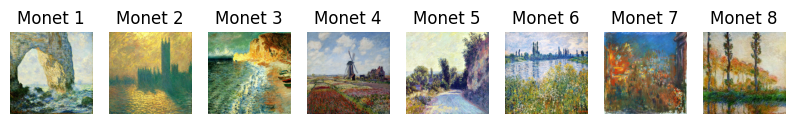

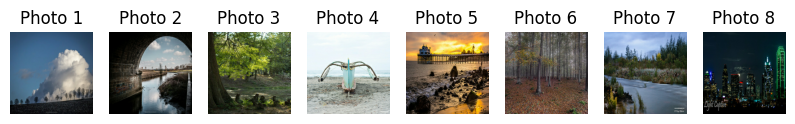

In [4]:
# display Monet and Photo images (8 each)

def display_samples(ds, title, samples=8):
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(ds.take(samples)):
        plt.subplot(1, samples, i+1)
        plt.title(f'{title} {i+1}')
        plt.imshow(img[0] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

display_samples(monet_ds, 'Monet')
display_samples(photo_ds, 'Photo')

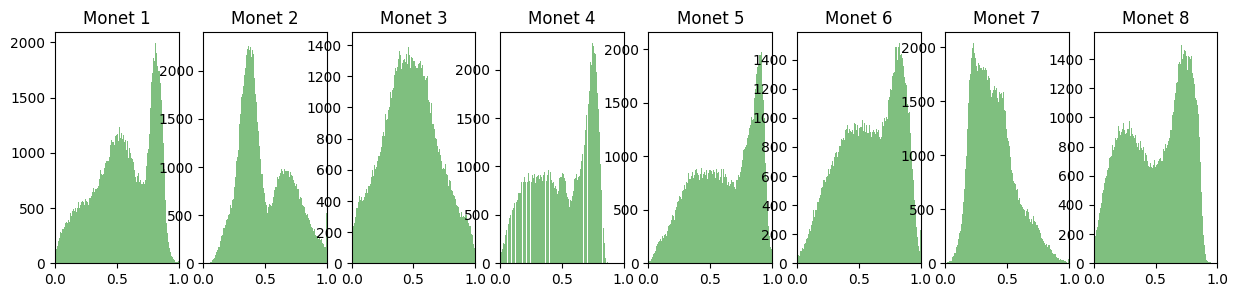

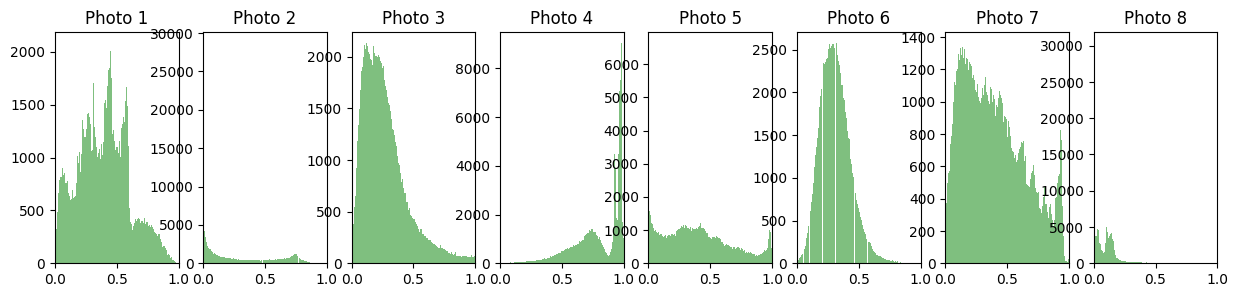

In [5]:
## This code compares the pixel intensity distribution for the monet images vs the photo images (8 samples)
def plot_intensity_histogram(ds, title, samples=8):
    plt.figure(figsize=(15, 3))
    for i, img in enumerate(ds.take(samples)):
        plt.subplot(1, samples, i+1)
        plt.title(f'{title} {i+1}')
        plt.hist((img[0] * 0.5 + 0.5).numpy().ravel(), bins=256, color='green', alpha=0.5)
        plt.xlim(0, 1)
    plt.show()

plot_intensity_histogram(monet_ds, 'Monet')
plot_intensity_histogram(photo_ds, 'Photo')

## Model

In creating my model, I followed the recommended tutorial by Amy Jang. I also relied heavily on the TensorFlow Pix2Pix and CycleGan documentation. I imported to tensorflow examples package and used the Pix2Pix model achitecture for the generator and discriminator. Some modifications of the include: using instance normalization for CycleGAN and using a unet generator. 

The model includes two generators and two discriminators and uses the unet architecture used in the Pix2Pix tensor flow package.
- Generator g translate the Monet images to photo
- Generator f translate photo images to Monet
- Discriminator x differentiates between Monet and generated Monets
- Discriminator y differentiates between photos and generated photos

In building the model, downsampling and upsampling are used.
- Downsampling reduces the dimensionality (width and height by factor of 2)
- Upsampling is a transposed convolutional layer to increases dimensionality

To determine feedback error, cycle consistency loss was used in addition to generator loss. Cycle consistency determines how close an image is to its original when it has been passed through the two generators and back. This was then multiplied by a factor LAMBDA and summed with the discriminator. The discriminator loss outputs the average of real and generated image loss. 

Adaptive moment estimation optimization was used.

The model was fit and trained. The algorithm for training the model was:
- Get predictions
- Calculate loss
- Use backpropogation for gradient calculations
- Use gradients for optimizers
  
I compared the models output image appearances and MiFID results for different numbers of epochs and lambda values. 

In [6]:
################
# Tensor Flow Documentation
# The code in this section is adapted from the Pix2Pix and CycleGAN examples on the TensorFlow site
# as well as the reference tutorial from the Kaggle competition
#
# https://www.tensorflow.org/tutorials/generative/cyclegan
# https://www.tensorflow.org/tutorials/generative/pix2pix
# https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial#Create-submission-file
################

In [7]:
#########
# Create Generators and Discriminators using Pix2Pix libraries
#########
OUTPUT_CHANNELS = 3
#Generator g is monet to photo generator f is photo to monet
generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)


### Sample Generator and Discriminator

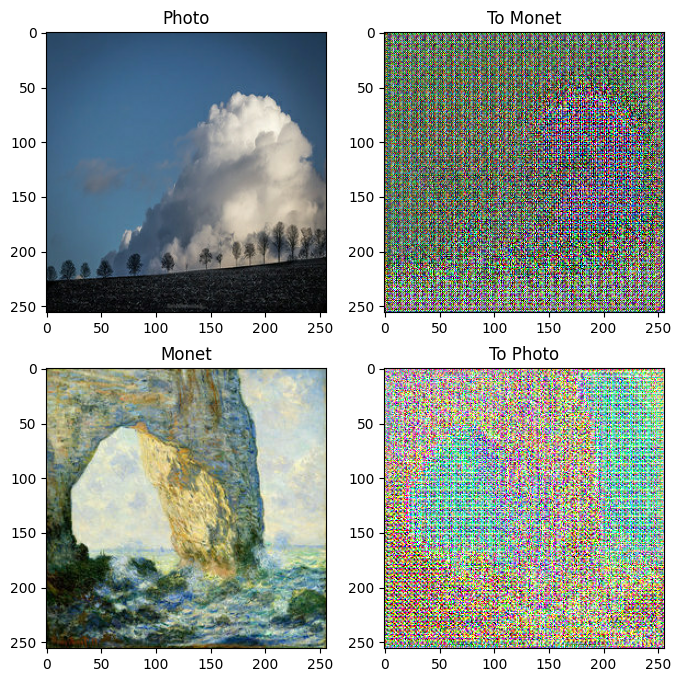

In [8]:
###this code passes one sample image of both photo and monet through the generator
sample_monet = next(iter(monet_ds))
sample_photo = next(iter(photo_ds))

to_monet = generator_g(sample_photo)
to_photo = generator_f(sample_monet)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_photo, to_monet, sample_monet, to_photo]
title = ['Photo', 'To Monet', 'Monet', 'To Photo']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()


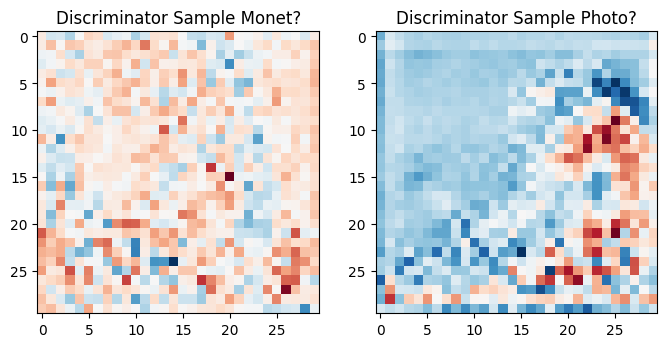

In [9]:
###this code passes one sample image of both photo and monet through the discriminator
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Discriminator Sample Monet?')
plt.imshow(discriminator_y(sample_monet)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Discriminator Sample Photo?')
plt.imshow(discriminator_x(sample_photo)[0, ..., -1], cmap='RdBu_r')

plt.show()

In [10]:
##### 
# Loss Functions
######

LAMBDA = 10

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)
  generated_loss = loss_obj(tf.zeros_like(generated), generated)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss * 0.5
    
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1    

def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss
    

In [11]:
### 
# Optimizers for generator and discriminator
#

# discrimintator x discriminates between real Monet and generated Monet
# discrimintator y discriminates between real photo and generated photo

generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

####### Train Checkpoint
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [12]:
EPOCHS = 50

# using variable "show" as flag to print or not print image
def generate_images(model, test_input, show=False):
  prediction = model(test_input)
  if show==True:  
      plt.figure(figsize=(12, 12))

      display_list = [test_input[0], prediction[0]]
      title = ['Input Image', 'Predicted Image']

      for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
      plt.show()
  return prediction   

### Training the Model

In [13]:
#######
# this function trains the model
######

@tf.function
def train_step(real_x, real_y):

  with tf.GradientTape(persistent=True) as tape:
    # Generator G transforms  Monet (x) to photo (y)
    # Generator F transforms  photo (y) to  Monet (x)

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))


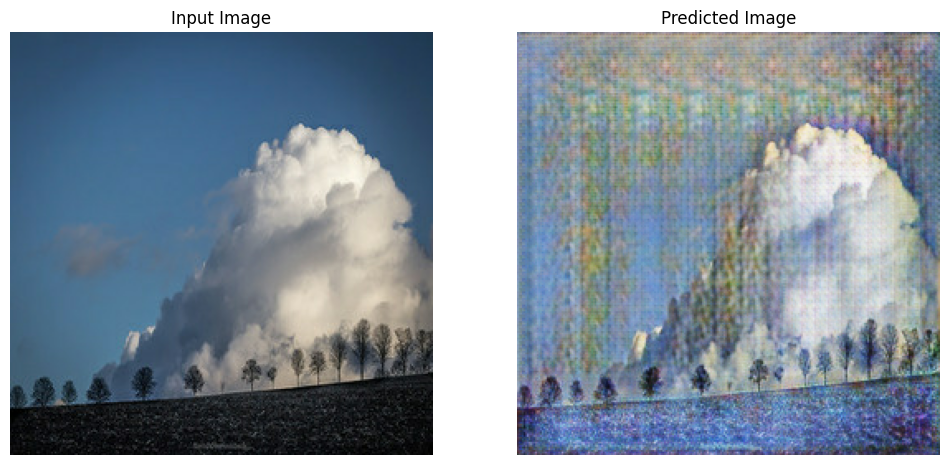

Saving checkpoint for epoch 50 at ./checkpoints/train/ckpt-10
Time taken for epoch 50 is 140.47425150871277 sec



In [14]:
# train the model and plot image to view progression of through the training epochs

for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((monet_ds, photo_ds)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # printing out image to see progress of model
  generate_images(generator_f, sample_photo, True)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))


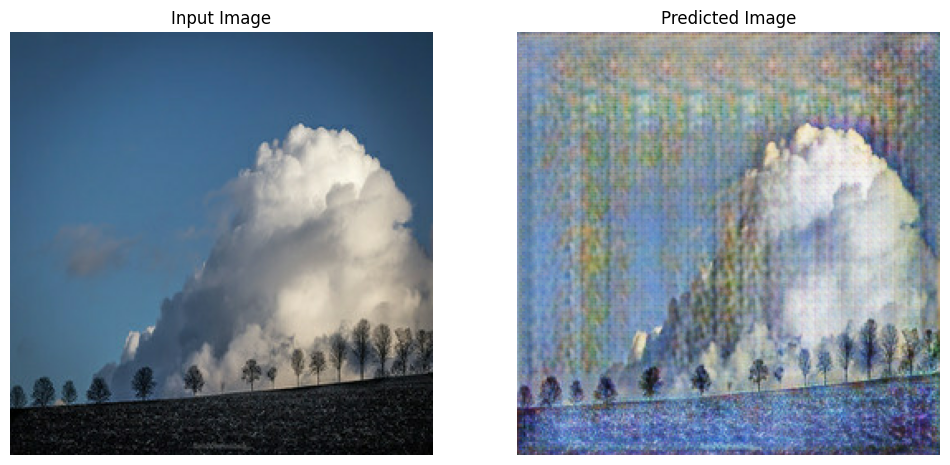

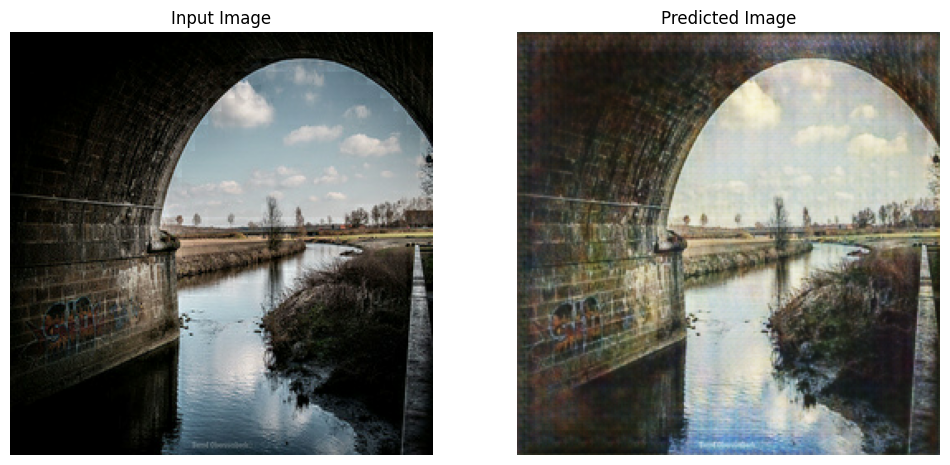

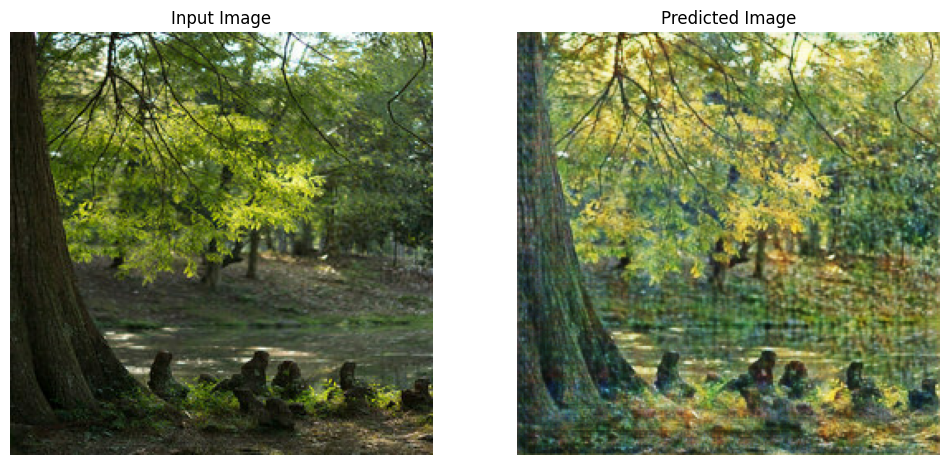

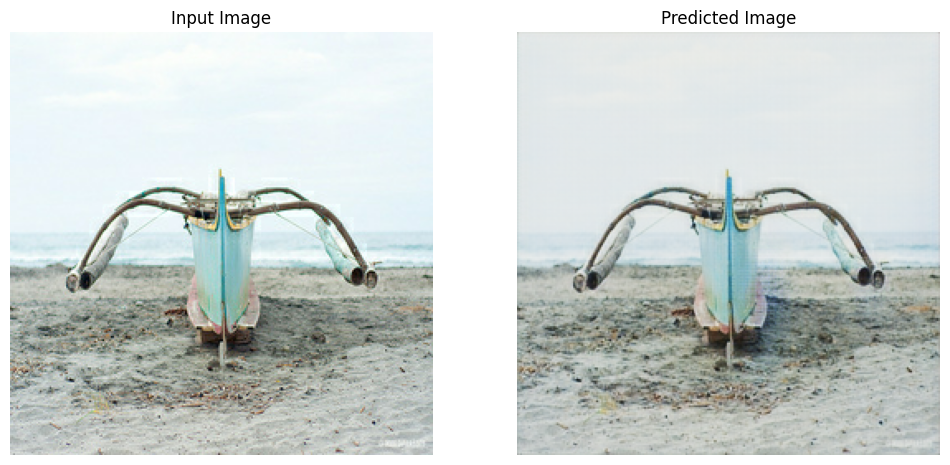

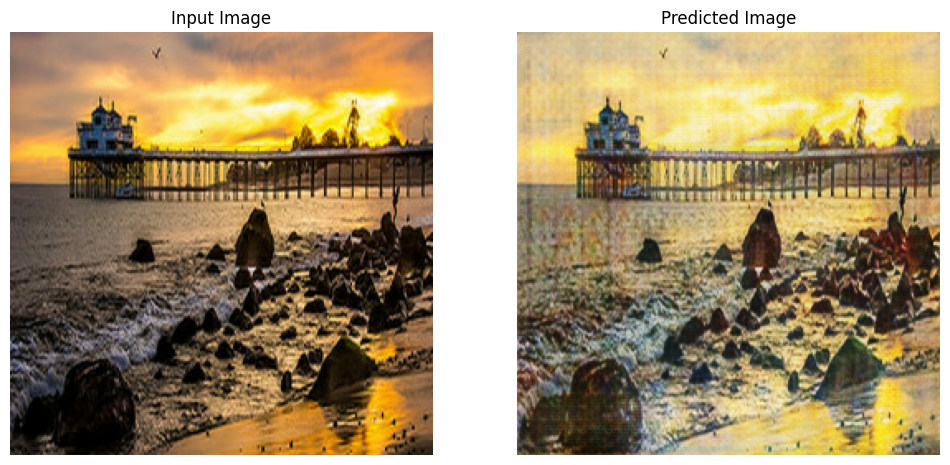

In [15]:
### Plot example images 

for i, img in enumerate(photo_ds.take(5)):
    prediction = generate_images(generator_f, img, True)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)


### Kaggle Competition Submission

In [1]:
# this code creates an image.zip file and submits to the kaggle competition
# best score - 58.69163 lambda 10 epochs 30

#! mkdir ../images

#i = 1
#for img in photo_ds:
 #   prediction = generate_images(generator_f, img)[0].numpy()
 #   prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
 #   im = PIL.Image.fromarray(prediction)
 #   im.save("../images/" + str(i) + ".jpg")
 #   i += 1


#shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")


## Results

The results show that as training epoch numbers are increased, the MiFID score improves. With a lower lambda the transformation of the photo images Monet style appeared more blurry and less sharp than those at a higher lambda. Increasing or decreasing the lambda (cycle consistency weighting factor) did not help much on MiFID performance. The value for lambda at 10 is consistent with the implementation by Zhu et al. (2017) on CycleGAN. 

|**Epoch** | **MiFID**|
|:---------|:-------------|
| 5 |	75.96040 |
| 15 |	69.7007 |
| 30 |	58.69163 |
| 50 |	53.36726 |




|**Lambda Factor** | **MiFID**|
|:---------|:-------------|
| 1 |	67.17925 |
| 10 |	58.69163 |
| 100 |	70.41863 |

## Conclusion

This project has been a fun opportunity to explore the potential of image-to-image translation using CycleGANs. I was able to successfully build a model using CycleGAN and the Pix2Pix package to transform example photos to Monet-painting style images. One key observation that was seen was how increasing the training epochs improved the results. Chaning the constinency cycle loss by adjusting the weight factor lambda did not help as much. One challenge with the project was the computational time it took to run the models. Upgrading to an accelerator such as GPU or TPU helped speed things up. Some future improvements could be to even further increase epochs and also try different generator architectures such as residual networks.

## References 

“Pix2Pix | TensorFlow Core.” TensorFlow, www.tensorflow.org/tutorials/generative/pix2pix.

“CycleGAN | TensorFlow Core.” TensorFlow, www.tensorflow.org/tutorials/generative/cyclegan.

“Monet CycleGAN Tutorial.” Kaggle.com, www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook.

Hui, Jonathan. “GAN — CycleGAN (Playing Magic with Pictures) - Jonathan Hui - Medium.” Medium, 15 June 2018, jonathan-hui.medium.com/gan-cyclegan-6a50e7600d7. Accessed 11 Nov. 2024.

Jianwenzhao. “Monet Style.” Kaggle.com, Kaggle, 15 Apr. 2023, www.kaggle.com/code/jianwenzhao/monet-style. Accessed 11 Nov. 2024.

Zhu, J.-Y., Park, T., Isola, P., & Efros, A. A. (2017). Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks. ArXiv (Cornell University). https://doi.org/10.48550/arxiv.1703.10593